<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/01_crawl_av_pages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AV-crawl: Advanced Web Crawler with Filtering and Markdown Conversion

#### Web crawling: Crawls, filters URLs, and converts HTML to Markdown.


# Table of Contents

- [1. Introduction](#1-Introduction)
- [2. Requirements & Setup](#2-Requirements--Setup)
- [3. Crawler Configuration and Utility Functions](#3-Crawler-Configuration-and-Utility-Functions)
- [4. Web Crawler With Filtering](#4-Web-Crawler-With-Filtering)
- [5. Convert Crawled HTML to Markdown](#5-Convert-Crawled-HTML-to-Markdown)
- [6. Add Agenda to the Cleaned data](#6-Add-Agenda-to-the-Cleaned-data)
- [7. Save and Inspect Results](#7.-Save-and-Inspect-Results)

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 224 (delta 73), reused 30 (delta 30), pack-reused 108 (from 1)
Receiving objects: 100% (224/224), 4.17 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (115/115), done.


## 1. Introduction

This notebook showcases a practical web-crawling workflow:

- Crawl **internal** links from a starting URL (here: Analytics Vidhya’s DataHack Summit site)
- Filter crawled URLs based on inclusion/exclusion patterns or domains
- Convert raw HTML content into clean Markdown text for easier reading or exporting


## 2. Requirements & Setup

First, install dependencies:
- `requests` and `beautifulsoup4` for crawling
- `markdownify` (easy, tested) or `html-to-markdown` (modern alternative) for HTML-to-Markdown



In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 M

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import deque
import time
import warnings
import urllib3

# Optional: Try html-to-markdown if preferred (pip install html-to-markdown)
try:
    from markdownify import markdownify as md_convert
except ImportError:
    # fallback to html-to-markdown if installed
    try:
        from html_to_markdown import convert_to_markdown as md_convert
    except ImportError:
        md_convert = None

# Suppress warnings for notebook clarity
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore")


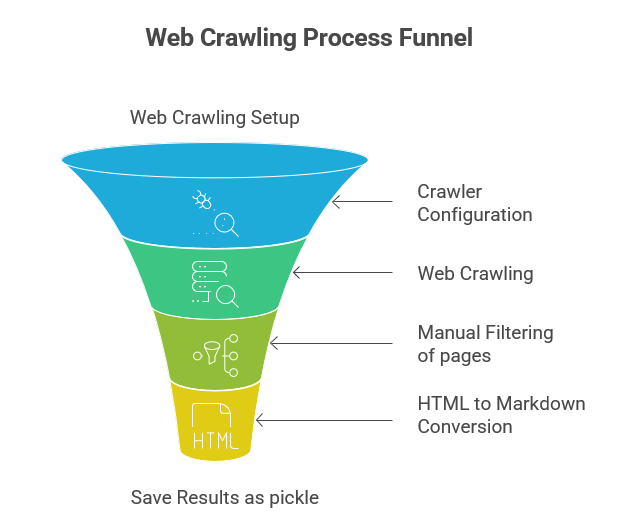

## 3. Crawler Configuration and Utility Functions

In [ ]:
START_URL = ["https://www.analyticsvidhya.com/datahacksummit/", "https://www.analyticsvidhya.com/datahacksummit-2025/speakers", "https://www.analyticsvidhya.com/datahacksummit-2025/sessions"]
BASE_DOMAIN = "www.analyticsvidhya.com"
MAX_PAGES = 10000

visited = set()
queue = deque(START_URL) # Initialize queue with individual URLs from the list
output_urls = []
page_data = []  # List of dicts: {'url', 'content'}

* is_valid_url(url): This function checks if a given string is a valid URL by parsing it and ensuring it has both a network location (domain) and a scheme (like http or https).
* is_internal_url(url, base_domain=BASE_DOMAIN): This function determines if a URL is internal to the specified base domain. It checks if the network location of the given URL matches the BASE_DOMAIN.
* url_passes_filters(url, include_patterns=None, exclude_patterns=None, domain_blocklist=None): This function checks if a URL passes the defined filtering rules. It can filter based on a blocklist of domains, a list of patterns to exclude, and/or a list of patterns to include. If include_patterns is specified, the URL must match at least one of those patterns to pass the filter.

In [ ]:
def is_valid_url(url):
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def is_internal_url(url, base_domain=BASE_DOMAIN):
    return urlparse(url).netloc == base_domain

def url_passes_filters(url, include_patterns=None, exclude_patterns=None, domain_blocklist=None):
    """
    Returns True if the URL passes filtering rules (inclusion, exclusion, blocklist).
    Patterns: lists of strings (keywords, domain names, substrings, etc.)
    """
    parsed = urlparse(url)
    # Block specific domains
    if domain_blocklist:
        for dom in domain_blocklist:
            if dom in parsed.netloc:
                return False
    # Block by substring pattern
    if exclude_patterns:
        for p in exclude_patterns:
            if p in url:
                return False
    # Allow only certain substrings if include_patterns specified
    if include_patterns:
        for p in include_patterns:
            if p in url:
                return True
        return False
    return True  # if nothing triggered above


## 4. Web Crawler With Filtering

* Filtering: unnecessary URLs, blocklist of unwanted domains & substrings, and/or allowlist (include patterns).
* Removing Duplicate URLs
* crawl the web page content using beautiful soup

In [ ]:
# Example: Block social or checkout domains, and allow only pages with 'datahack' in the path
DOMAIN_BLOCKLIST = ['facebook.com', 'linkedin.com', 'twitter.com', 'instagram.com', 'explara.com']
EXCLUDE_PATTERNS = ['privacy', 'policy', 'checkout', 'login']  # Exclusion substrings
INCLUDE_PATTERNS = None  # Example: ['datahack']

remove_urls = ['https://www.analyticsvidhya.com/datahacksummit-2025/sessions/llmops-productionalizing-real-world-applications-with-llms-2',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-real-world-agentic-ai-applications-with-ag2-autogen',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/build-a-production-ready-multi-agent-application-with-crewai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/from-theory-to-practice-training-llms-reinforcement-learning-and-ai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/generative-ai-for-business-leaders',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentops-building-and-deploying-ai-agents',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai',
'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/mastering-llms-training-fine-tuning-and-best-practices-2',
"https://www.analyticsvidhya.com/datahacksummit-2025/awards",
"https://www.analyticsvidhya.com/datahacksummit/."]

def crawl():
    pages_crawled = 0
    while queue and pages_crawled < MAX_PAGES:
        current_url = queue.popleft()

        # Filter out the specific URL at the beginning
        if current_url in remove_urls:
            print(f"Skipping: {current_url}")
            continue

        # Check for desired URL prefixes at the beginning
        if not (current_url.startswith("https://www.analyticsvidhya.com/datahacksummit/") or current_url.startswith("https://www.analyticsvidhya.com/datahacksummit-2025/")):
            continue

        if current_url in visited or not url_passes_filters(
            current_url, INCLUDE_PATTERNS, EXCLUDE_PATTERNS, DOMAIN_BLOCKLIST):
            continue
        visited.add(current_url)
        pages_crawled += 1
        print(f"[{pages_crawled}] Crawling: {current_url}")
        try:
            response = requests.get(current_url, timeout=8, verify=False)
            response.raise_for_status()
        except Exception as e:
            print(f"Failed: {e}")
            continue

        output_urls.append(current_url)
        page_data.append({'url': current_url, 'content': response.text})

        soup = BeautifulSoup(response.text, "html.parser")
        for a_tag in soup.find_all("a", href=True):
            href = a_tag["href"]
            full_url = urljoin(current_url, href)
            normalized_url = full_url.split("#")[0].rstrip("/")
            # This inner check is still needed for newly discovered links
            if (
                is_valid_url(normalized_url)
                and is_internal_url(normalized_url)
                and normalized_url not in visited # Ensure no duplicates are added
            ):
                if url_passes_filters(normalized_url, INCLUDE_PATTERNS, EXCLUDE_PATTERNS, DOMAIN_BLOCKLIST):
                    queue.append(normalized_url)
    print(f"\n✅ {len(output_urls)} pages crawled after filtering.")

In [ ]:
# Run the crawler
crawl()

[1] Crawling: https://www.analyticsvidhya.com/datahacksummit/
[2] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/speakers
[3] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/sessions
Skipping: https://www.analyticsvidhya.com/datahacksummit-2025/awards
[4] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai
[5] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai
[6] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-real-world-agentic-ai-applications-with-ag2-autogen
[7] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2
[8] Crawling: https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2
[9] Crawling: https://www.ana

In [ ]:
filter_target_urls = [
    "https://www.analyticsvidhya.com/datahacksummit-2025/sessions",
    "https://www.analyticsvidhya.com/datahacksummit-2025/sessions/",
    "https://www.analyticsvidhya.com/datahacksummit-2025/speakers",
    "https://www.analyticsvidhya.com/datahacksummit-2025/speakers/",

]

In [ ]:
filter_target_urls = [
    "https://www.analyticsvidhya.com/datahacksummit-2025/sessions",
    "https://www.analyticsvidhya.com/datahacksummit-2025/sessions/",
    "https://www.analyticsvidhya.com/datahacksummit-2025/speakers",
    "https://www.analyticsvidhya.com/datahacksummit-2025/speakers/",
]
# Remove entries from page_data if the URL is in filter_target_urls
cleaned_page_data = [item for item in page_data if item['url'] not in filter_target_urls]

# Now, page_data contains only the filtered URLs
page_data = cleaned_page_data

In [ ]:
len(page_data)

155

## 5. Convert Crawled HTML to Markdown

Use **html2text** to transform page HTML to markdown for easier interpretation


In [ ]:
# Convert all HTML contents to markdown (if converter is available)
import html2text
from IPython.display import Markdown

def convert_html_to_markdown():
    """Creates and configures an html2text converter."""
    converter = html2text.HTML2Text()
    converter.ignore_links = False       # Set True if you want to remove links
    converter.ignore_images = True       # Set False if you want to include image URLs
    converter.body_width = 0             # Prevents line wrapping
    return converter

def extract_section(text, start_keyword=None, end_keywords=None):
    """
    Extracts text between a start keyword and one of several end keywords.

    Args:
        text: The input string.
        start_keyword: The keyword to start extraction after.
        end_keywords: A list of keywords to end extraction before.

    Returns:
        The extracted text, or the original text if keywords are not found.
    """
    if start_keyword:
        parts = text.split(start_keyword, maxsplit=1)
        text = parts[1].strip() if len(parts) > 1 else ""

    if end_keywords:
        for keyword in end_keywords:
            parts = text.split(keyword, maxsplit=1)
            text = parts[0].strip() if len(parts) > 1 else text.strip()
    return text

cleaned_page_content = []
converter = convert_html_to_markdown()

end_keywords = ["Participate", "Keynote", "Workshop Details", "Past Edition", "Download Brochure"]

for entry in page_data:
    markdown = converter.handle(entry["content"])
    cleaned_text = extract_section(markdown, start_keyword="Download Brochure", end_keywords=end_keywords)

    cleaned_page_content.append({
        "url": entry["url"],
        "content": cleaned_text
    })

##6. Add Agenda to the Cleaned data


In [ ]:
import pandas as pd
from IPython.display import Markdown

# Load your Excel file
df = pd.read_excel("/content/Agentic_KAG/data/DHS2025_Agenda.xlsx")
df.fillna("", inplace=True)  # Replace NaN with empty string
# Convert the 'Date' column to datetime objects and then format them as dates
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
# Convert time columns to datetime objects and then format them as times
df['Start Time'] = pd.to_datetime(df['Start Time'].astype(str)).dt.strftime('%H:%M')
df['End Time'] = pd.to_datetime(df['End Time'].astype(str)).dt.strftime('%H:%M')



In [ ]:
# Convert the DataFrame to a markdown table
markdown_table = df.to_markdown(index=False)

# Display the markdown table
display(Markdown(markdown_table))


| Day   | Date       | Venue   | Session Type   | Start Time   | End Time   | Topic                                                                       | Speaker                                              |
|:------|:-----------|:--------|:---------------|:-------------|:-----------|:----------------------------------------------------------------------------|:-----------------------------------------------------|
| Day 1 | 2025-08-20 | ChatGPT | Opening Remark | 10:00        | 10:20      | Opening Remarks                                                             | Kunal Jain                                           |
| Day 1 | 2025-08-20 | ChatGPT | Keynote        | 10:20        | 11:20      | Responsible AI in Medical Imaging – A Case Study                            | Dr. Geetha Manjunath                                 |
| Day 1 | 2025-08-20 | ChatGPT | Awards         | 11:20        | 11:40      | AV Luminary Awards - Top 7 GenAI Leaders                                    |                                                      |
| Day 1 | 2025-08-20 | ChatGPT | Break          | 11:40        | 12:00      | TEA (Networking Break)                                                      |                                                      |
| Day 1 | 2025-08-20 | ChatGPT | PowerTalk      | 12:00        | 12:40      | Building Blocks of Successful AI                                            | Arijit Mallick                                       |
| Day 1 | 2025-08-20 | ChatGPT | Hack Session   | 12:45        | 13:35      | Building Effective Agentic AI Systems: Lessons from the Field               | Dipanjan Sarkar                                      |
| Day 1 | 2025-08-20 | ChatGPT | Break          | 13:35        | 14:25      | LUNCH (Networking Break)                                                    |                                                      |
| Day 1 | 2025-08-20 | ChatGPT | PowerTalk      | 14:25        | 15:05      | vLLM + llm-d: Scalable, Efficient LLM Inference in Kubernetes               | Atul Ramesh Deshpande                                |
| Day 1 | 2025-08-20 | ChatGPT | Keynote        | 15:30        | 16:20      | TBA                                                                         | Srikanth Velamakanni                                 |
| Day 1 | 2025-08-20 | ChatGPT | Break          | 16:20        | 16:40      | TEA (Networking Break)                                                      |                                                      |
| Day 1 | 2025-08-20 | ChatGPT | Hack Session   | 16:40        | 17:30      | Deploying GenAI Safely: Strategies for Trustworthy LLMs                     | Gauri Kholkar                                        |
| Day 1 | 2025-08-20 | Claude  | Hack Session   | 12:00        | 12:50      | Agents at Scale: Engineering Reliable GenAI Systems for Production          | Kartik Nighania                                      |
| Day 1 | 2025-08-20 | Claude  | Hack Session   | 12:55        | 13:45      | Building a Scalable Healthcare Voice AI Contact Center with Pipecat         | Ashish Tripathy                                      |
| Day 1 | 2025-08-20 | Claude  | Break          | 13:45        | 14:35      | LUNCH (Networking Break)                                                    |                                                      |
| Day 1 | 2025-08-20 | Claude  | Hack Session   | 14:35        | 15:25      | Human-In-The-Loop Agentic Systems                                           | Deepak Sharma                                        |
| Day 1 | 2025-08-20 | Claude  | Hack Session   | 15:30        | 16:20      | Bridging the AI Agent Gap: Interoperability with A2A and MCP Protocols      | Nikhil Rana                                          |
| Day 1 | 2025-08-20 | Claude  | Break          | 16:20        | 16:40      | TEA (Networking Break)                                                      |                                                      |
| Day 1 | 2025-08-20 | Claude  | Hack Session   | 16:40        | 17:30      | Collaborative Multi-Agent Framework for Robust SEO Content Generation       | Anshu Kumar                                          |
| Day 1 | 2025-08-20 | Gemini  | Hack Session   | 12:00        | 12:50      | Agentic Knowledge Augmented Generation: The Next Leap After RAG             | Arun Prakash Asokan                                  |
| Day 1 | 2025-08-20 | Gemini  | Hack Session   | 12:55        | 13:45      | Measuring Uncertainty in LLMs and Optimal use of SLMs                       | Kuldeep Jiwani                                       |
| Day 1 | 2025-08-20 | Gemini  | Break          | 13:45        | 14:45      | LUNCH (Networking Break)                                                    |                                                      |
| Day 1 | 2025-08-20 | Gemini  | PowerTalk      | 14:45        | 15:25      | Agentic AI Meets Responsible AI: Designing Safe Autonomous Systems          | Praveen Kumar GS                                     |
| Day 1 | 2025-08-20 | Gemini  | PowerTalk      | 15:30        | 16:10      | Productionizing Agents : An Agent Factory Approach                          | Krishnakumar Menon                                   |
| Day 1 | 2025-08-20 | Gemini  | Break          | 16:10        | 16:25      | TEA (Networking Break)                                                      |                                                      |
| Day 1 | 2025-08-20 | Gemini  | Hack Session   | 16:25        | 17:15      | Automating Vehicle Inspections with Multimodal AI and Gemini on GCP         | Vignesh Kumar                                        |
| Day 1 | 2025-08-20 | Grok    | PowerTalk      | 12:00        | 12:40      | Onboarding AI Agents with Human Values                                      | Syed Quiser Ahmed                                    |
| Day 1 | 2025-08-20 | Grok    | PowerTalk      | 12:45        | 13:25      | TBA                                                                         | TBA                                                  |
| Day 1 | 2025-08-20 | Grok    | Break          | 13:25        | 14:15      | LUNCH (Networking Break)                                                    |                                                      |
| Day 1 | 2025-08-20 | Grok    | Hack Session   | 14:15        | 15:05      | Aligning Responsible AI with Probabilistic World of LLMs & Agents           | Shubhradeep Nandi                                    |
| Day 1 | 2025-08-20 | Grok    | Hack Session   | 16:40        | 17:30      | Vibe Coding in Action: Building Real Applications with AI Assistance        | Tanika Gupta                                         |
| Day 2 | 2025-08-21 | ChatGPT | Hack Session   | 09:30        | 10:20      | Quantifying Our Confidence in Neural Networks and AI                        | Joshua Starmer                                       |
| Day 2 | 2025-08-21 | ChatGPT | Break          | 10:20        | 10:40      | TEA (Networking Break)                                                      |                                                      |
| Day 2 | 2025-08-21 | ChatGPT | Keynote        | 10:40        | 11:40      | Inclusive AI and Open Challenges                                            | Manish Gupta                                         |
| Day 2 | 2025-08-21 | ChatGPT | Awards         | 11:40        | 11:55      | AV Luminary Awards - Top 7 GenAI Scientists                                 |                                                      |
| Day 2 | 2025-08-21 | ChatGPT | Hack Session   | 12:20        | 13:10      | The Promise and Pitfalls of Synthetic Data Generation                       | Abhishek Divekar                                     |
| Day 2 | 2025-08-21 | ChatGPT | Break          | 13:10        | 14:00      | LUNCH (Networking Break)                                                    |                                                      |
| Day 2 | 2025-08-21 | ChatGPT | Hack Session   | 14:00        | 14:50      | From LLMs to Agentic AI: Solving New Problems with Multi-Agent Systems      | Alessandro Romano                                    |
| Day 2 | 2025-08-21 | ChatGPT | Hack Panel     | 14:55        | 15:55      | Vibe Coding Showdown: Building Applications with AI Assistants              | Anuvrat Parashar; Anand S; Ravi RS Nadimpalli        |
| Day 2 | 2025-08-21 | ChatGPT | Break          | 15:55        | 16:10      | TEA (Networking Break)                                                      |                                                      |
| Day 2 | 2025-08-21 | ChatGPT | Hack Session   | 16:10        | 17:00      | Search Query Optimization Using Retrieval-Augmented Generation (RAG)        | Pankaj Agarwal                                       |
| Day 2 | 2025-08-21 | Claude  | Hack Session   | 09:30        | 10:20      | From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI      | Logesh Kumar Umapathi                                |
| Day 2 | 2025-08-21 | Claude  | Hack Session   | 12:05        | 12:55      | Fast and Accurate Conversational Agents: Beyond Function Calling            | Daksh Varshneya                                      |
| Day 2 | 2025-08-21 | Claude  | Break          | 13:00        | 13:50      | LUNCH (Networking Break)                                                    |                                                      |
| Day 2 | 2025-08-21 | Claude  | Hack Session   | 13:50        | 14:50      | Full-Stack Agentic AI: Build, Evaluate, and Scale with NVIDIA Tools         | Saurav Agarwal                                       |
| Day 2 | 2025-08-21 | Claude  | Hack Session   | 14:55        | 15:45      | Beyond PoCs: Building Real-World Agentic Systems                            | Miguel Otero Pedrido                                 |
| Day 2 | 2025-08-21 | Claude  | Break          | 15:45        | 16:00      | TEA (Networking Break)                                                      |                                                      |
| Day 2 | 2025-08-21 | Claude  | Hack Session   | 16:00        | 17:00      | The Missing Piece of AI Apps: Evaluation                                    | Ayush Thakur                                         |
| Day 2 | 2025-08-21 | Gemini  | PowerTalk      | 09:30        | 10:10      | Evaluating GenAI Models: Case Studies in Enterprise and Healthcare          | Dr. Kiran R                                          |
| Day 2 | 2025-08-21 | Gemini  | Hack Session   | 12:05        | 13:00      | Understanding AI Agents with MCP                                            | Nitin Agarwal; Rutvik Acharya                        |
| Day 2 | 2025-08-21 | Gemini  | Break          | 13:00        | 13:50      | LUNCH (Networking Break)                                                    |                                                      |
| Day 2 | 2025-08-21 | Gemini  | Hack Session   | 13:50        | 14:40      | RIP, Data Scientists                                                        | Anand S                                              |
| Day 2 | 2025-08-21 | Gemini  | PowerTalk      | 14:45        | 15:25      | Zero to Million: How GenAI Agents are Revolutionizing Performance Marketing | Krishna Kumar Tiwari                                 |
| Day 2 | 2025-08-21 | Gemini  | PowerTalk      | 15:30        | 16:10      | How GenAI is Being Leveraged in the Web3 Ecosystems                         | Rohan Rao                                            |
| Day 2 | 2025-08-21 | Gemini  | Break          | 16:10        | 16:25      | TEA (Networking Break)                                                      |                                                      |
| Day 2 | 2025-08-21 | Gemini  | Hack Session   | 16:25        | 17:15      | Towards Sustainable AI: Effective LLM Compression Techniques                | Ruchi Awasthi                                        |
| Day 2 | 2025-08-21 | Grok    | Hack Session   | 09:30        | 10:20      | Model Context Protocol in Media: Choosing the Right Metrics & Strategy      | Hitesh Nayak                                         |
| Day 2 | 2025-08-21 | Grok    | Hack Session   | 12:20        | 13:10      | LLMs Are Boring. How Can We Make Them More Interesting?                     | Harshad Khadilkar                                    |
| Day 2 | 2025-08-21 | Grok    | Break          | 13:20        | 14:20      | LUNCH (Networking Break)                                                    |                                                      |
| Day 2 | 2025-08-21 | Grok    | Hack Session   | 14:20        | 15:10      | From Risk to Retention: The Anatomy of a Customer Saved                     | Pavak Biswal; Abhilash Kulkarni                      |
| Day 2 | 2025-08-21 | Grok    | Hack Session   | 15:15        | 16:05      | From Idea to Production with GenAI : Realizing the Art of the Possible      | Karan Sindwani                                       |
| Day 2 | 2025-08-21 | Grok    | Break          | 16:05        | 16:20      | TEA (Networking Break)                                                      |                                                      |
| Day 2 | 2025-08-21 | Grok    | Hack Session   | 16:20        | 17:10      | Post‑Training Is Back: From Prompts to Policies                             | Aashay Sachdeva                                      |
| Day 3 | 2025-08-22 | ChatGPT | Hack Session   | 09:30        | 10:20      | Why GenAI and LLMs Fail and How Fine-Tuning Helps Them                      | Vijay Gabale                                         |
| Day 3 | 2025-08-22 | ChatGPT | Hack Session   | 10:25        | 11:15      | MassGen: Scaling AI Through Multi-Agent Collaboration                       | Chi Wang                                             |
| Day 3 | 2025-08-22 | ChatGPT | Break          | 11:15        | 11:35      | TEA (Networking Break)                                                      |                                                      |
| Day 3 | 2025-08-22 | ChatGPT | Keynote        | 11:35        | 12:35      | Building India’s AI Ecosystem: From Vision to Sovereignty                   | Pratyush Kumar                                       |
| Day 3 | 2025-08-22 | ChatGPT | Awards         | 12:35        | 12:50      | AV Luminary Awards - Top 7 AI Community Contributors                        |                                                      |
| Day 3 | 2025-08-22 | ChatGPT | Hack Session   | 13:10        | 14:00      | Architecting AI: Practical Patterns for Multi-Agentic Workflows             | Pranjal Singh                                        |
| Day 3 | 2025-08-22 | ChatGPT | Break          | 14:00        | 14:50      | LUNCH (Networking Break)                                                    |                                                      |
| Day 3 | 2025-08-22 | ChatGPT | Hack Panel     | 14:50        | 15:50      | AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks              | Mayank Aggarwal; Praneeth Paikray; Sanathraj Narayan |
| Day 3 | 2025-08-22 | ChatGPT | Hack Session   | 15:55        | 16:45      | Building Responsible AI Agents with Guardrails and Safety in Action         | Anuj Saini                                           |
| Day 3 | 2025-08-22 | ChatGPT | Break          | 16:45        | 17:00      | TEA (Networking Break)                                                      |                                                      |
| Day 3 | 2025-08-22 | ChatGPT | Closing Remark | 17:00        | 17:15      | Closing Remarks                                                             | Kunal Jain                                           |
| Day 3 | 2025-08-22 | Claude  | Hack Session   | 09:30        | 10:20      | A Visual Guide to Attention Mechanism in LLMs                               | Luis Serrano                                         |
| Day 3 | 2025-08-22 | Claude  | Hack Session   | 10:25        | 11:15      | Creative AI Agents: Open Tools for Collaborative Media Creation             | Dhruv Nair                                           |
| Day 3 | 2025-08-22 | Claude  | Hack Session   | 12:55        | 13:45      | Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning      | Praneeth Paikray                                     |
| Day 3 | 2025-08-22 | Claude  | Break          | 13:45        | 14:45      | LUNCH (Networking Break)                                                    |                                                      |
| Day 3 | 2025-08-22 | Claude  | Hack Session   | 14:45        | 15:45      | Red Teaming GenAI: Securing Systems from the Inside Out                     | Satnam Singh; Shivaraj Mulimani                      |
| Day 3 | 2025-08-22 | Claude  | Hack Session   | 15:50        | 16:50      | From Vision to Action: Multi-Modal Agentic AI in Real-World Use             | Pradeep Kumar                                        |
| Day 3 | 2025-08-22 | Claude  | Break          | 16:50        | 17:00      | TEA (Networking Break)                                                      |                                                      |
| Day 3 | 2025-08-22 | Gemini  | Hack Session   | 09:30        | 10:20      | TBA                                                                         | TBA                                                  |
| Day 3 | 2025-08-22 | Gemini  | Hack Session   | 10:25        | 11:15      | Empowering Data Insights with Large Language Models                         | Aditya Iyengar                                       |
| Day 3 | 2025-08-22 | Gemini  | Hack Session   | 12:55        | 13:45      | Automate Everything: Building Agentic AI Workflows with No-Code Tools       | Mayank Aggarwal                                      |
| Day 3 | 2025-08-22 | Gemini  | Break          | 13:45        | 14:45      | LUNCH (Networking Break)                                                    |                                                      |
| Day 3 | 2025-08-22 | Gemini  | Hack Session   | 14:45        | 15:45      | Detecting and Mitigating Risks in Agentic AI                                | Bhaskarjit Sarmah                                    |
| Day 3 | 2025-08-22 | Gemini  | Hack Session   | 15:50        | 16:40      | Multi-Modal GenAI for Energy Infrastructure Inspection Reports              | Prakalp Somawanshi                                   |
| Day 3 | 2025-08-22 | Gemini  | Break          | 16:40        | 17:00      | TEA (Networking Break)                                                      |                                                      |
| Day 3 | 2025-08-22 | Grok    | Hack Session   | 09:30        | 10:20      | Scaling Test-time Inference Compute & Advent of Reasoning Models            | Jayita Bhattacharyya                                 |
| Day 3 | 2025-08-22 | Grok    | Hack Session   | 10:25        | 11:15      | Mastering Agentic Workflows with LangGraph                                  | Sanathraj Narayan                                    |
| Day 3 | 2025-08-22 | Grok    | Hack Session   | 13:10        | 14:00      | AI Voice Agent: The Future of Human-Computer Interaction                    | Ranjani Mani; Manoranjan Rajguru                     |
| Day 3 | 2025-08-22 | Grok    | Break          | 14:00        | 15:00      | LUNCH (Networking Break)                                                    |                                                      |
| Day 3 | 2025-08-22 | Grok    | Hack Session   | 15:00        | 16:00      | Building Real-Time Multi-Agent AI for Public Travel Systems                 | Manpreet Singh                                       |
| Day 3 | 2025-08-22 | Grok    | Hack Session   | 16:00        | 16:50      | Agent to Agent Protocol: Benefits and Workflows                             | Avinash Pathak                                       |
| Day 3 | 2025-08-22 | Grok    | Break          | 16:50        | 17:00      | TEA (Networking Break)                                                      |                                                      |

Including the Schedule webpage as the URL (metadata) to the Agenda included

In [ ]:
cleaned_page_content.append({
        "url": 'https://www.analyticsvidhya.com/datahacksummit/#schedule',
        "content": markdown_table
    })

## 7. Save and Inspect Results


In [ ]:
import pickle
# Save for reuse
with open("/content/Agentic_KAG/data/page_data.pkl", "wb") as f:
    pickle.dump(cleaned_page_content, f)

In [ ]:
# Quick summary: crawled URLs and markdown preview
print(f"Total pages: {len(cleaned_page_content)}")
print("--- Example URLs ---")
for page in cleaned_page_content[:5]:
    print(page['url'])

print("\n--- Markdown Snippet from First Page ---")
Markdown(cleaned_page_content[0]['content'])


Total pages: 156
--- Example URLs ---
https://www.analyticsvidhya.com/datahacksummit/
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-real-world-agentic-ai-applications-with-ag2-autogen
https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2

--- Markdown Snippet from First Page ---


# The AI Trinity

## Powering the Future

### Generative | Agentic | Responsible

## India's Most Futuristic AI Conference

### August 20-23, 2025  • The Leela Bhartiya City Bengaluru 

Send WhatsApp Updates

Download Agenda

Your browser does not support the video tag. 

## 1200+

### Attendees

## 80+

### AI Talks

## 50+

### Hack Sessions

## 10+

### Workshops

## Hands-on AI Workshops

### [Mastering Intelligent Agents: A Deep Dive into Agentic AI Dipanjan Sarkar - Analytics Vidhya  ](/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)

[ 🔥 Most Trending Mastering Real-World Multi-Agent Systems Alessandro Romano - Kuehne+Nagel  ](/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)

[ Almost Sold Out Mastering Real-World Agentic AI Applications with AG2 (AutoGen) Hrushikesh Dokala - Atlan, Qingyun Wu - AG2, Chi Wang - AG2  ](/datahacksummit-2025/workshops/mastering-real-world-agentic-ai-applications-with-ag2-autogen)

[ ⚡️ Filling Fast LLMOps – Productionalizing Real-World Applications with LLMs and Agents Kartik Nighania - Typewise  ](/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)

[ ⚡️ Filling Fast Mastering LLMs: Training, Fine-Tuning, and Best Practices Raghav Bali - Delivery Hero  ](/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2)

### [AgentOps: Building and Deploying AI Agents Bhaskarjit Sarmah - Domyn  ](/datahacksummit-2025/workshops/agentops-building-and-deploying-ai-agents)

### [From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents Joshua Starmer - StatQuest, Luis Serrano - Serrano Academy  ](/datahacksummit-2025/workshops/from-theory-to-practice-training-llms-reinforcement-learning-and-ai)

[ 💎 Best Value Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language Miguel Otero Pedrido - The Neural Maze  ](/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)

### [Agentic AI & Generative AI for Business Leaders David Zakkam - Uber  ](/datahacksummit-2025/workshops/generative-ai-for-business-leaders)

### [Agentic RAG Workshop: From Fundamentals to Real-World Implementations Arun Prakash Asokan - Novartis  ](/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

Download